<a href="https://colab.research.google.com/github/Vishy-A/DeepLearning/blob/main/finalproject/train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import os
import numpy as np
import scipy.misc as m

from PIL import Image

from torch.utils import data
from torch.utils.data import DataLoader
import torch.nn as nn
import sklearn.metrics as skm
import torch.optim as optim
from tqdm import tqdm
import matplotlib.pyplot as plt
import torch.nn.functional as F


from google.colab import drive
drive.mount('/content/drive')

path_data = "content/drive/My Drive/Real-Time Project/cityscapes-imports/"

Mounted at /content/drive


In [2]:
device = (torch.device('cuda') if torch.cuda.is_available()
          else torch.device('cpu'))
print(f"Training on device {device}.")

Training on device cuda.


In [3]:

learning_rate = 0.0001
train_epochs = 2
n_classes = 19
batch_size = 1
num_workers = 1

# Adapted from dataset loader written by meetshah1995 with modifications
# https://github.com/meetshah1995/pytorch-semseg/blob/master/ptsemseg/loader/cityscapes_loader.py

def recursive_glob(rootdir=".", suffix=""):
    return [
        os.path.join(looproot, filename)
        for looproot, _, filenames in os.walk(rootdir)
        for filename in filenames
        if filename.endswith(suffix)
    ]


class cityscapesLoader(data.Dataset):
    colors = [
        #[0,   0,   0],
        [128, 64, 128],
        [244, 35, 232],
        [70, 70, 70],
        [102, 102, 156],
        [190, 153, 153],
        [153, 153, 153],
        [250, 170, 30],
        [220, 220, 0],
        [107, 142, 35],
        [152, 251, 152],
        [0, 130, 180],
        [220, 20, 60],
        [255, 0, 0],
        [0, 0, 142],
        [0, 0, 70],
        [0, 60, 100],
        [0, 80, 100],
        [0, 0, 230],
        [119, 11, 32],
    ]


    label_colours = dict(zip(range(19), colors))

    def __init__(
        self,
        root,
        split="train",
        is_transform=True,
        img_size=(512, 1024),
    ):
        self.root = root
        self.split = split
        self.is_transform = is_transform
        self.n_classes = 19
        self.img_size = img_size if isinstance(img_size, tuple) else (img_size, img_size)
        self.files = {}

        self.images_base = os.path.join("drive/My Drive/Real-Time Project/cityscapes-imports/leftImg8bit", self.split)
        self.annotations_base = os.path.join("drive/My Drive/Real-Time Project/cityscapes-imports/gtFine", self.split)


        self.files[split] = recursive_glob(rootdir=self.images_base, suffix=".png")

        #classes that are not recognized/marked (tunnel, bridge, caravan, etc)
        self.void_classes = [0, 1, 2, 3, 4, 5, 6, 9, 10, 14, 15, 16, 18, 29, 30, -1]

        #19 classes that are recognized (car. person, road, etc)
        self.valid_classes = [7, 8, 11, 12, 13, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 31, 32, 33,]

        # these are 19 + 1; "unlabelled" is extra
        self.class_names = [
            "unlabelled",
            "road",
            "sidewalk",
            "building",
            "wall",
            "fence",
            "pole",
            "traffic_light",
            "traffic_sign",
            "vegetation",
            "terrain",
            "sky",
            "person",
            "rider",
            "car",
            "truck",
            "bus",
            "train",
            "motorcycle",
            "bicycle",
        ]


        self.ignore_index = 250


        self.class_map = dict(zip(self.valid_classes, range(19)))

        if not self.files[split]:
            raise Exception("No files for split=[%s] found in %s" % (split, self.images_base))


        print("Found %d %s images" % (len(self.files[split]), split))

    def __len__(self):
        return len(self.files[self.split])

    def __getitem__(self, index):

        img_path = self.files[self.split][index].rstrip()


        lbl_path = os.path.join(
            self.annotations_base,
            img_path.split(os.sep)[-2],
            os.path.basename(img_path)[:-15] + "gtFine_labelIds.png",
        )


        img = Image.open(img_path)
        img = img.convert('RGB')
        img = np.array(img)

        img = np.array(img, dtype=np.uint8)


        lbl = Image.open(lbl_path)
        lbl = lbl.convert('L') #Grayscale
        lbl = np.array(lbl)

        lbl = self.encode_segmap(np.array(lbl, dtype=np.uint8))

        if self.is_transform:
            img, lbl = self.transform(img, lbl)

        return img, lbl

    def transform(self, img, lbl):

        img = Image.fromarray(img)
        img = img.resize((self.img_size[1], self.img_size[0]))
        img = np.array(img)

        img = img[:, :, ::-1]  # RGB to BGR for preprocessing

        img = img.astype(np.float64)

        img = img.transpose(2, 0, 1)


        classes = np.unique(lbl)
        lbl = lbl.astype(float)
        lbl = Image.fromarray(lbl)
        lbl = lbl.resize((self.img_size[1], self.img_size[0]), Image.NEAREST)
        lbl = np.array(lbl, dtype=np.uint8)
        lbl = lbl.astype(int)

        # if not np.array_equal(classes, np.unique(lbl)):
        #   print("Classes and unique labels don't match. Skipping this image.")
        #   return torch.empty((3, self.img_size[0], self.img_size[1])).float(), torch.empty((self.img_size[0], self.img_size[1])).long()


      #   #DEBUGGING class discrepancy
      #  # print("Classes:", classes)
      #  # print("Classes:", np.unique(lbl))

      #  # if not np.all(classes == np.unique(lbl)):
      #       print("WARN: resizing labels yielded fewer classes")

      #   #if not np.all(np.unique(lbl[lbl != self.ignore_index]) < self.n_classes):
      #       print("after det", classes, np.unique(lbl))
      #       raise ValueError("Segmentation map contained invalid class values")

        img = torch.from_numpy(img).float()
        lbl = torch.from_numpy(lbl).long()

        return img, lbl

    def decode_segmap(self, temp):
        r = temp.copy()
        g = temp.copy()
        b = temp.copy()
        for l in range(0, self.n_classes):
            r[temp == l] = self.label_colours[l][0]
            g[temp == l] = self.label_colours[l][1]
            b[temp == l] = self.label_colours[l][2]

        rgb = np.zeros((temp.shape[0], temp.shape[1], 3))
        rgb[:, :, 0] = r / 255.0
        rgb[:, :, 1] = g / 255.0
        rgb[:, :, 2] = b / 255.0
        return rgb





    def encode_segmap(self, mask):

      for _voidc in self.void_classes:
          mask[mask == _voidc] = 250

      for _validc in self.valid_classes:
          mask[mask == _validc] = self.valid_classes.index(_validc)

      return mask


In [4]:


train_data = cityscapesLoader(
    root = path_data,
    split='train'
    )

val_data = cityscapesLoader(
    root = path_data,
    split='val'
    )

train_loader = DataLoader(
    train_data,
    batch_size = batch_size,
    shuffle=True,
    num_workers = num_workers,

)

val_loader = DataLoader(
    val_data,
    batch_size = batch_size,
    num_workers = num_workers,
)

class UpsampledConv(nn.Module):
    def __init__(self, ch_in, ch_out):
        super(UpsampledConv, self).__init__()
        self.up = nn.Sequential(
            nn.Upsample(scale_factor=2),
            nn.Conv2d(ch_in, ch_out, kernel_size=3, stride=1, padding=1, bias=True),
            nn.BatchNorm2d(ch_out),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        x = self.up(x)
        return x


class RepeatedConv(nn.Module):
    def __init__(self, ch_out):
        super(RepeatedConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(ch_out, ch_out, kernel_size=3, stride=1, padding=1, bias=True),
            nn.BatchNorm2d(ch_out),
            nn.ReLU(inplace=True))

    def forward(self, x):
        for i in range(2):
            if i == 0:
                x_rec = self.conv(x)
            x_rec = self.conv(x + x_rec)
        return x_rec

class RecurrentConv(nn.Module):
    def __init__(self, ch_in, ch_out):
        super(RecurrentConv, self).__init__()
        self.Repeat_block = nn.Sequential(RepeatedConv(ch_out),RepeatedConv(ch_out))
        self.Conv = nn.Conv2d(ch_in, ch_out, 1, 1, 0)

    def forward(self, input_img):
        input_img = self.Conv(input_img)
        conv_input_img = self.Repeat_block(input_img)
        return input_img + conv_input_img


Found 586 train images
Found 174 val images


In [5]:
## Model Architecture syntax based off

class R2U_Net(nn.Module):
    def __init__(self, img_ch=3, output_ch=19):
        super(R2U_Net, self).__init__()

        self.MaxPool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.channel_1 = 64
        self.channel_2 = 2*self.channel_1
        self.channel_3 = 2*self.channel_2
        self.channel_4 = 2*self.channel_3
        self.channel_5 = 2*self.channel_4



        self.channels = [self.channel_1, self.channel_2, self.channel_3, self.channel_4, self.channel_5]

        self.Layer1 = RecurrentConv(img_ch, self.channels[0])
        self.Layer2 = RecurrentConv(self.channels[0], self.channels[1])
        self.Layer3 = RecurrentConv(self.channels[1], self.channels[2])
        self.Layer4 = RecurrentConv(self.channels[2], self.channels[3])
        self.Layer5 = RecurrentConv(self.channels[3], self.channels[4])



        self.DeConvLayer5 = UpsampledConv(self.channels[4], self.channels[3])
        self.DeConvLayer4 = UpsampledConv(self.channels[3],self.channels[2])
        self.DeConvLayer3 = UpsampledConv(self.channels[2], self.channels[1])
        self.DeConvLayer2 = UpsampledConv(self.channels[1], self.channels[0])

        self.Up_Layer5 = RecurrentConv(self.channels[4], self.channels[3])
        self.Up_Layer4 = RecurrentConv(self.channels[3], self.channels[2])
        self.Up_Layer3 = RecurrentConv(self.channels[2], self.channels[1])
        self.Up_Layer2 = RecurrentConv(self.channels[1], self.channels[0])

        self.Conv = nn.Conv2d(self.channels[0], output_ch, kernel_size=1, stride=1, padding=0)



    def forward(self, x):

        conv1 = self.Layer1(x)
        mp1 = self.MaxPool(conv1)
        conv2 = self.Layer2(mp1)
        mp2 = self.MaxPool(conv2)
        conv3 = self.Layer3(mp2)
        mp3 = self.MaxPool(conv3)
        conv4 = self.Layer4(mp3)
        mp4 = self.MaxPool(conv4)
        conv5 = self.Layer5(mp4)

        deconv5 = self.DeConvLayer5(conv5)
        deconv5 = torch.cat((conv4, deconv5), dim=1)
        deconv5 = self.Up_Layer5(deconv5)
        deconv4 = self.DeConvLayer4(deconv5)
        deconv4 = torch.cat((conv3, deconv4), dim=1)
        deconv4 = self.Up_Layer4(deconv4)
        deconv3 = self.DeConvLayer3(deconv4)
        deconv3 = torch.cat((conv2, deconv3), dim=1)
        deconv3 = self.Up_Layer3(deconv3)
        deconv2 = self.DeConvLayer2(deconv3)
        deconv2 = torch.cat((conv1, deconv2), dim=1)
        deconv2 = self.Up_Layer2(deconv2)
        output = self.Conv(deconv2)

        return output

In [6]:
model = R2U_Net().to(device)

optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Cross Entropy Loss adapted from https://github.com/meetshah1995/pytorch-semseg/blob/master/ptsemseg/loss/loss.py

# Regular nn.CrossEntropyLoss() did not work

def crossentropyloss(input, target, weight=None, size_average=True):
    n, c, h, w = input.size()
    nt, ht, wt = target.size()

    # Handle inconsistent size between input and target
    if h != ht and w != wt:  # upsample labels
        input = F.interpolate(input, size=(ht, wt), mode="bilinear", align_corners=True)

    input = input.transpose(1, 2).transpose(2, 3).contiguous().view(-1, c)
    target = target.view(-1)
    loss = F.cross_entropy(
        input, target, weight=weight, size_average=size_average, ignore_index=250
    )
    return loss



'''We have used skelarn libraries to calculate Accuracy'''

def get_metrics(gt_label, pred_label):
    #Accuracy Score
    acc = skm.accuracy_score(gt_label, pred_label, normalize=True)




    result_gm_sh = [acc]
    return(result_gm_sh)

'''
Calculation of confusion matrix from :
https://github.com/meetshah1995/pytorch-semseg/blob/master/ptsemseg/metrics.py

'''

class runningScore(object):
    def __init__(self, n_classes):
        self.n_classes = n_classes
        self.confusion_matrix = np.zeros((n_classes, n_classes))

    def _fast_hist(self, label_true, label_pred, n_class):
        mask = (label_true >= 0) & (label_true < n_class)
        hist = np.bincount(
            n_class * label_true[mask].astype(int) + label_pred[mask], minlength=n_class ** 2
        ).reshape(n_class, n_class)
        return hist

    def update(self, label_trues, label_preds):
        for lt, lp in zip(label_trues, label_preds):
            self.confusion_matrix += self._fast_hist(lt.flatten(), lp.flatten(), self.n_classes)

    def get_scores(self):
        hist = self.confusion_matrix


        TP = np.diag(hist)
        TN = hist.sum() - hist.sum(axis = 1) - hist.sum(axis = 0) + np.diag(hist)
        FP = hist.sum(axis = 1) - TP
        FN = hist.sum(axis = 0) - TP


        # Recall: TP / TP + FN
        recall_cls = (TP) / (TP + FN + 1e-6)
        recall = np.nanmean(recall_cls)

        # Precision: TP / (TP + FP)
        prec_cls = (TP) / (TP + FP + 1e-6)
        prec = np.nanmean(prec_cls)

        # F1 = 2 * Precision * Recall / Precision + Recall
        f1 = (2 * prec * recall) / (prec + recall + 1e-6)

        return (
            {
                "Precision": prec,
                "Recall": recall,
                "F1": f1,
            }
        )

    def reset(self):
        self.confusion_matrix = np.zeros((self.n_classes, self.n_classes))

In [7]:
def train(train_loader, model, optimizer, epoch_i, epoch_total):
        count = 0

        # List to cumulate loss during iterations
        loss_list = []
        for (images, labels) in train_loader:
            count += 1

            model.train()

            images = images.to(device)
            labels = labels.to(device)

            pred = model(images)

            loss = crossentropyloss(pred, labels)
            loss_list.append(loss)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if count % 25 == 0:
                fmt_str = "Image: {:d} in epoch: [{:d}/{:d}]  and Loss: {:.4f}"
                print_str = fmt_str.format(
                    count,
                    epoch_i + 1,
                    epoch_total,
                    loss.item()
                )
                print(print_str)


        return(loss_list)

def validate(val_loader, model, epoch_i):

    model.eval()

    running_metrics_val = runningScore(19)

    acc_sh = []


    with torch.no_grad():
        for image_num, (val_images, val_labels) in tqdm(enumerate(val_loader)):

            val_images = val_images.to(device)
            val_labels = val_labels.to(device)

            val_pred = model(val_images)


            pred = val_pred.data.max(1)[1].cpu().numpy()
            gt = val_labels.data.cpu().numpy()

            running_metrics_val.update(gt, pred)
            sh_metrics = get_metrics(gt.flatten(), pred.flatten())
            acc_sh.append(sh_metrics[0])


#            # break for testing purpose
#             if image_num == 10:
#                 break

    score = running_metrics_val.get_scores()
    running_metrics_val.reset()

    acc_s = sum(acc_sh)/len(acc_sh)
    score["acc"] = acc_s

    print("Different Metrics were: ", score)
    return(score)

if __name__ == "__main__":

    loss_all_epochs = []

    Precision_ = []
    Recall_ = []
    F1_ = []
    acc_ = []

    for epoch_i in range(train_epochs):
        print(f"Epoch {epoch_i + 1}\n-------------------------------")

        loss_i = train(train_loader, model, optimizer, epoch_i, train_epochs)
        loss_all_epochs.append(loss_i)


        dummylist = validate(val_loader, model, epoch_i)

        Precision_.append(dummylist["Precision"])
        Recall_.append(dummylist["Recall"])
        F1_.append(dummylist["F1"])
        acc_.append(dummylist["acc"])




Epoch 1
-------------------------------


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/local/lib/python3.10/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


Image: 25 in epoch: [1/2]  and Loss: 1.7198
Image: 50 in epoch: [1/2]  and Loss: 2.9154
Image: 75 in epoch: [1/2]  and Loss: 1.3479
Image: 100 in epoch: [1/2]  and Loss: 1.2061
Image: 125 in epoch: [1/2]  and Loss: 1.1331
Image: 150 in epoch: [1/2]  and Loss: 1.1863
Image: 175 in epoch: [1/2]  and Loss: 0.9959
Image: 200 in epoch: [1/2]  and Loss: 1.1238
Image: 225 in epoch: [1/2]  and Loss: 1.1814
Image: 250 in epoch: [1/2]  and Loss: 2.6121
Image: 275 in epoch: [1/2]  and Loss: 0.8720
Image: 300 in epoch: [1/2]  and Loss: 0.9927
Image: 325 in epoch: [1/2]  and Loss: 1.3835
Image: 350 in epoch: [1/2]  and Loss: 1.1078
Image: 375 in epoch: [1/2]  and Loss: 1.2442
Image: 400 in epoch: [1/2]  and Loss: 0.7769
Image: 425 in epoch: [1/2]  and Loss: 1.0150
Image: 450 in epoch: [1/2]  and Loss: 0.7218
Image: 475 in epoch: [1/2]  and Loss: 1.0855
Image: 500 in epoch: [1/2]  and Loss: 0.7781
Image: 525 in epoch: [1/2]  and Loss: 0.5693
Image: 550 in epoch: [1/2]  and Loss: 1.1068
Image: 575 in

174it [03:07,  1.08s/it]

Different Metrics were:  {'Precision': 0.21422265861427808, 'Recall': 0.25073228894816973, 'F1': 0.23104355507445667, 'acc': 0.6149988174438477}
Epoch 2
-------------------------------



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/local/lib/python3.10/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


Image: 25 in epoch: [2/2]  and Loss: 0.6510
Image: 50 in epoch: [2/2]  and Loss: 0.5268
Image: 75 in epoch: [2/2]  and Loss: 0.9733
Image: 100 in epoch: [2/2]  and Loss: 0.9992
Image: 125 in epoch: [2/2]  and Loss: 1.0852
Image: 150 in epoch: [2/2]  and Loss: 0.6583
Image: 175 in epoch: [2/2]  and Loss: 0.4618
Image: 200 in epoch: [2/2]  and Loss: 0.9396
Image: 225 in epoch: [2/2]  and Loss: 0.8591
Image: 250 in epoch: [2/2]  and Loss: 0.5380
Image: 275 in epoch: [2/2]  and Loss: 0.6896
Image: 300 in epoch: [2/2]  and Loss: 1.4217
Image: 325 in epoch: [2/2]  and Loss: 0.5547
Image: 350 in epoch: [2/2]  and Loss: 0.5467
Image: 375 in epoch: [2/2]  and Loss: 1.0542
Image: 400 in epoch: [2/2]  and Loss: 1.3687
Image: 425 in epoch: [2/2]  and Loss: 0.6294
Image: 450 in epoch: [2/2]  and Loss: 1.1079
Image: 475 in epoch: [2/2]  and Loss: 0.8903
Image: 500 in epoch: [2/2]  and Loss: 0.6483
Image: 525 in epoch: [2/2]  and Loss: 1.5854
Image: 550 in epoch: [2/2]  and Loss: 0.4898
Image: 575 in

174it [01:23,  2.07it/s]

Different Metrics were:  {'Precision': 0.28140075823052063, 'Recall': 0.2922134869615758, 'F1': 0.28670471186181357, 'acc': 0.6886617397439891}


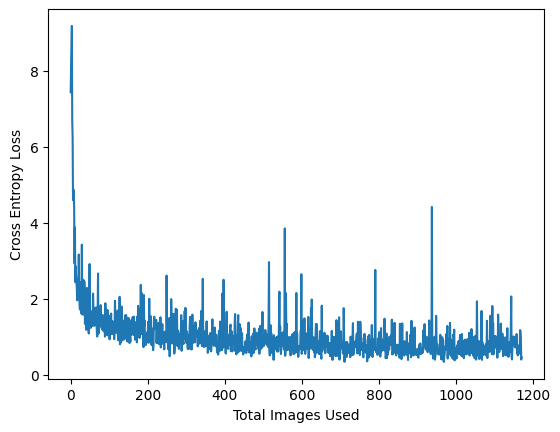

In [8]:

loss_1d_list = [item for sublist in loss_all_epochs for item in sublist]
loss_list_numpy = []
for i in range(len(loss_1d_list)):
    z = loss_1d_list[i].cpu().detach().numpy()
    loss_list_numpy.append(z)

plt.xlabel("Total Images Used")
plt.ylabel("Cross Entropy Loss")
plt.plot(loss_list_numpy)
plt.show()

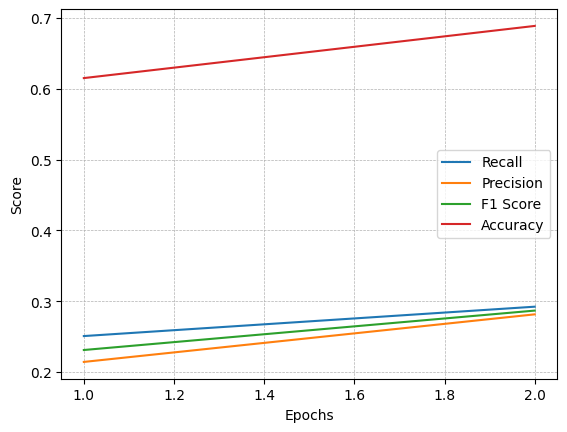

In [9]:
plt.clf()

x = [i for i in range(1, train_epochs + 1)]

plt.plot(x,Recall_, label='Recall')
plt.plot(x,Precision_, label='Precision')
plt.plot(x,F1_, label='F1 Score')
plt.plot(x,acc_, label='Accuracy')


plt.grid(linestyle = '--', linewidth = 0.5)

plt.xlabel("Epochs")
plt.ylabel("Score")
plt.legend()
plt.show()

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
0it [00:00, ?it/s]

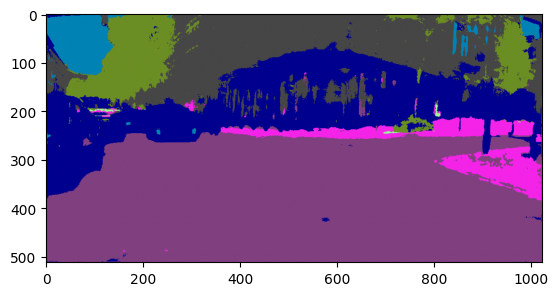

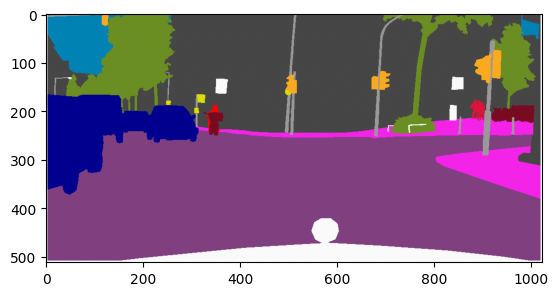

50it [00:13,  4.03it/s]

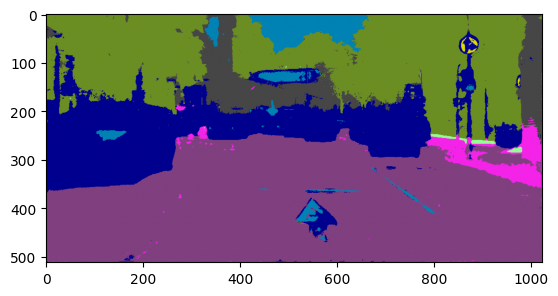

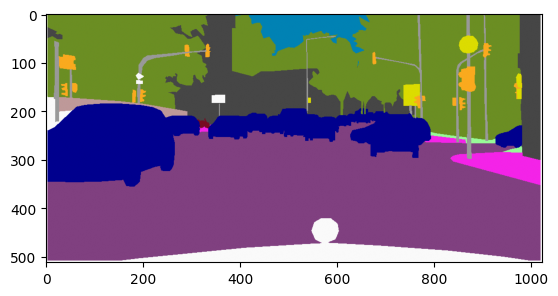

100it [00:25,  4.10it/s]

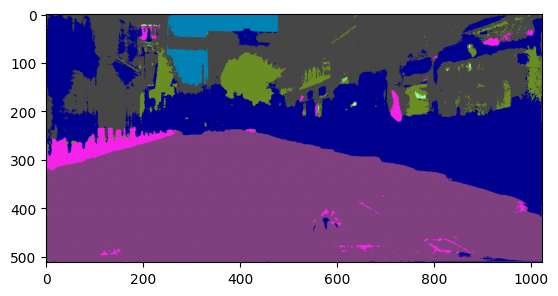

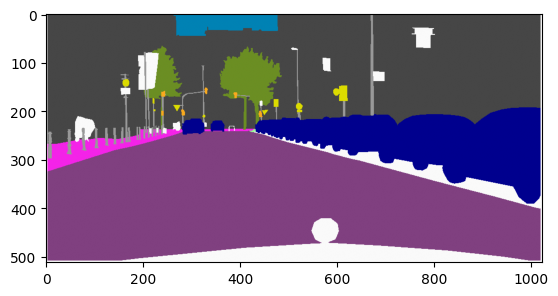

150it [00:38,  4.11it/s]

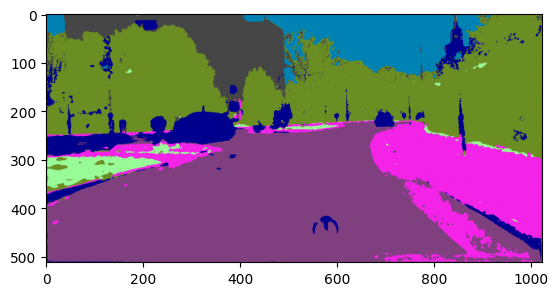

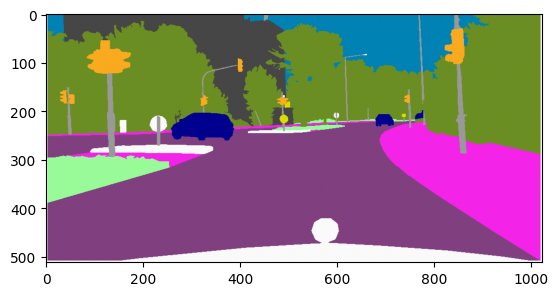

174it [00:44,  3.88it/s]


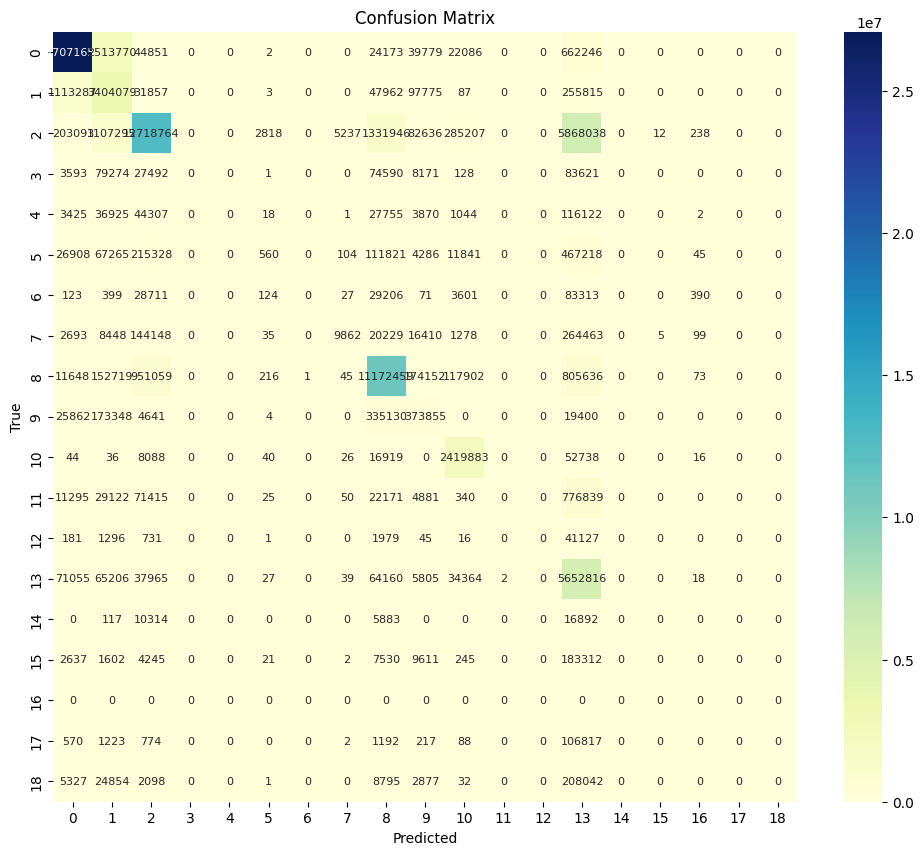

In [10]:
import seaborn as sns
# tldr: to make layers behave differently during inference (vs training)
model.eval()
running_metrics_val = runningScore(19)

with torch.no_grad():

    for image_num, (val_images, val_labels) in tqdm(enumerate(val_loader)):

        val_images = val_images.to(device)
        val_labels = val_labels.to(device)

        # model prediction
        val_pred = model(val_images)

        # Coverting val_pred from (1, 19, 512, 1024) to (1, 512, 1024)
        # considering predictions with highest scores for each pixel among 19 classes
        prediction = val_pred.data.max(1)[1].cpu().numpy()
        ground_truth = val_labels.data.cpu().numpy()

        # Update running metrics
        running_metrics_val.update(ground_truth, prediction)

        # replace 100 to change number of images to print.
        # 500 % 100 = 5. So, we will get 5 predictions and ground truths
        if image_num % 50 == 0:

            # Model Prediction
            decoded_pred = val_data.decode_segmap(prediction[0])
            plt.imshow(decoded_pred)
            plt.show()
            plt.clf()

            # Ground Truth
            decode_gt = val_data.decode_segmap(ground_truth[0])
            plt.imshow(decode_gt)
            plt.show()

    conf_matrix_int = running_metrics_val.confusion_matrix.astype(int)

    # Plot the heatmap with adjusted font size
    plt.figure(figsize=(12, 10))
    sns.heatmap(conf_matrix_int, annot=True, cmap="YlGnBu", fmt="d", annot_kws={"size": 8})
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()
